# NLP: Yelp Review to Rating
### Authors: Tanvee Desai and Tanner Arrizabalaga

Hello! In this project, we will be looking over Yelp reviews (data available here: https://www.yelp.com/dataset) and utilizing ML/DL to accurately predict what the reviews star rating is based solely on text.

This project is split into the following parts
- Libraries
- EDA
- Data Cleaning
    - Stop word removal, HTML parsing, punctuation removal, etc.
    - Creation of a cleaned *and* stemmed dataset
- Model Implementation
    - Simple BOW Model Neural Network
    - LSTM
    - Bidirectional LSTM
    - One vs. All LSTM Approach
- Exploring Challenges
    - Challenge 5
    - Challenge 6

### Importing necessary libraries

In [359]:
# General Libraries
import json
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# NLP
import nltk
import re
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer


# ML/DL
import tensorflow as tf
import pickle

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Activation, Dropout, Embedding, Conv1D, MaxPooling1D, LSTM, BatchNormalization, SpatialDropout1D, Bidirectional
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras import utils
from keras import regularizers
from keras.models import load_model
from keras.initializers import Constant
from keras.utils import plot_model

In [360]:
yelp = pd.read_json("./yelp_review_training_dataset.jsonl", lines = True)
yelp.head()

,review_id,text,stars
0,Q1sbwvVQXV2734tPgoKj4Q,Total bill for this horrible service? Over $8G...,1
1,GJXCdrto3ASJOqKeVWPi6Q,I *adore* Travis at the Hard Rock's new Kelly ...,5
2,2TzJjDVDEuAW6MR5Vuc1ug,I have to say that this office really has it t...,5
3,yi0R0Ugj_xUx_Nek0-_Qig,Went in for a lunch. Steak sandwich was delici...,5
4,11a8sVPMUFtaC7_ABRkmtw,Today was my second out of three sessions I ha...,1


How large is the data?

In [361]:
yelp.shape

(533581, 3)

### EDA - Stars
Not too much to go off of, but let's get a general understanding of our data. How many nulls do we have?

In [362]:
yelp.isna().sum()

review_id    0
text         0
stars        0
dtype: int64

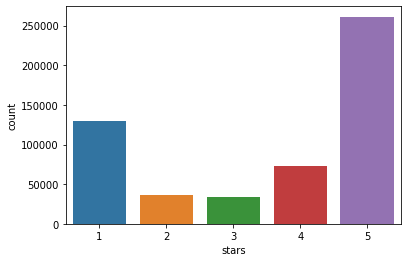

In [363]:
sns.countplot(yelp['stars'])

One thing we can potentially look at is whether or not the reviews are balanced. Let's say >=4 is positive, and <4 is negative. If we do see a significant difference in positive and negative reviews, we can balance it before training.

Positive to negative review ratio:  1.6679183395916979


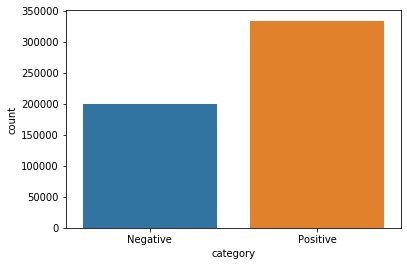

In [364]:
def pos_or_neg(x):
    if x >= 4:
        return "Positive"
    else:
        return "Negative"
    
yelp['category'] = yelp['stars'].apply(pos_or_neg)

sns.countplot(yelp['category'])
num_pos = np.count_nonzero(yelp['category'] == 'Positive')
num_neg = np.count_nonzero(yelp['category'] == 'Negative')
print("Positive to negative review ratio: ", num_pos / num_neg)

There are roughly 1 and 2/3 times as many positive reviews as negative reviews. We will first try no class balancing when building the model, but may turn to class balancing later on.

### Data Cleaning - Text

In [365]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
print(STOPWORDS)

def adjust_stopwords(stopwords):
    words_to_keep = set(['nor', 'not', 'very', 'no', 'few', 'too', 'doesn', 'didn', 'wasn', 'ain', 
                        "doesn't", "isn't", "hasn't", 'shouldn', "weren't", "don't", "didn't", 
                        "shouldn't", "wouldn't", "won't", "above", "below", "haven't", "shan't", "weren"
                        "but", "wouldn", "mightn", "under", "mustn't", "over", "won", "aren", "wasn't", 
                        "than"])
    return stopwords - words_to_keep

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    new_text = BeautifulSoup(text, "lxml").text # HTML decoding
    new_text = new_text.lower() # lowercase text
    new_text = REPLACE_BY_SPACE_RE.sub(' ', new_text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    new_text = BAD_SYMBOLS_RE.sub(' ', new_text) # delete symbols which are in BAD_SYMBOLS_RE from text
   
    ps = PorterStemmer()
    
    new_text = ' '.join(ps.stem(word) for word in new_text.split()) # keeping all words, no stop word removal
#     new_text = ' '.join(ps.stem(word) for word in new_text.split() if word not in STOPWORDS) # delete stopwords from text and stem
    return new_text

# STOPWORDS = adjust_stopwords(STOPWORDS)
print(STOPWORDS)

{'their', 'its', 'his', 're', "wouldn't", "you've", 'was', 'we', 'of', "you're", 'a', 'do', 'while', 'been', 'into', 's', 'what', "should've", 'for', 'before', 'shan', 'o', 'mustn', 'because', 'or', "it's", 'they', 'and', 'off', 'other', 'd', 'your', 'more', "shouldn't", 'during', 'who', "that'll", 'further', 'didn', 'so', 'from', 'all', 'wouldn', 'about', "mustn't", 'him', 'it', 'am', 'himself', 'doing', 'aren', 'an', 'are', 'being', 'now', 'shouldn', 'over', 'to', 'you', 'y', 'than', 'just', 'with', "mightn't", 'yourselves', 'some', 'the', 'be', 'between', 'having', "wasn't", 'same', 'yours', 'down', "needn't", 'were', 'he', 'll', 'how', 'doesn', 'but', 'this', 'ma', 'itself', 'themselves', 'once', 'had', 'those', 'is', 'not', 'm', 'ain', "couldn't", "you'll", "aren't", 'mightn', 'by', 'any', 'where', 'own', 'on', 'hasn', 'both', "doesn't", 'then', "shan't", 'until', 'under', 't', "isn't", 'through', 'wasn', 'did', 'them', 'won', 'up', "don't", 'such', 'after', 'here', 've', 'these',

In [ ]:
%%time
yelp['text'] = yelp['text'].apply(clean_text)
yelp.to_csv('cleaned_yelp_stemmed.csv')

In [366]:
text_1 = "\"Good morning, cocktails for you?\" \nWait...what? Oh...it's Vegas!\n\nDining here, you best not be dieting because this place is literally the definition of excess, but in a good way. I'm a sucker for benedicts so that was awesome. \nService was really great too and the staff was so welcoming. It was our first stop just after landing so really appreciate the service.\n\nBack in Hawaii this reminds me of Zippys or Anna Millers - that home feeling. Prices are a bit high, but for what you get it's totally worth it. Will remember this place if I ever return to Vegas in the future."
text_2 = "80 bucks, thirty minutes to fix my shattered iPhone screen. Verizon won't help you so go here"
text_3 = "Tr\u00e8s grand caf\u00e9, mais aussi calme et reposant, je m'y suis arr\u00eat\u00e9 alors que j'\u00e9tais dans le coin.\n\nOn peu y mang\u00e9 le midi, prendre une p\u00e2tisserie ou un caf\u00e9/th\u00e9. \n\nJ'ai prit un th\u00e9 qui \u00e9tait vraiment bon, et je me suis pos\u00e9 devant une des grandes baies vitr\u00e9es sur un coussin et j'ai relax\u00e9 compl\u00e8tement pendant 2 heures. \n\nMais c'est aussi une coop\u00e9rative d'artiste, avec une estrade etc.\n\nIl y a aussi un magasin Bio \u00e0 l'entr\u00e9e o\u00f9 vous retrouverez des savons, huile d'olive et plein d'autres produits."
text_4 = "Sadly, as of July 28, 2016, Silverstein bakery is permanently closed. I went there today in person and found the bad news posted on their door. :("
text_5 = "I went here  they were about to close but the cashier was especially helpful ..but I guess they were tired of work..."

clean_text(text_4)

'sadli as of juli 28 2016 silverstein bakeri is perman close i went there today in person and found the bad news post on their door'

# Model Implementation

### Evaluation
#### 1. Average Star Error (Average Absolute offset between predicted and true number of stars)
#### 2. Accuracy (Exact Match -- Number of exactly predicted star ratings / total samples)

In [367]:
from keras.losses import mean_absolute_error, binary_crossentropy, categorical_crossentropy

def my_custom_loss_ova(y_true, y_pred):
    mse = mean_absolute_error(y_true, y_pred)
    crossentropy = binary_crossentropy(y_true, y_pred)
    return mse + crossentropy

def my_custom_loss(y_true, y_pred):
    mse = mean_absolute_error(y_true, y_pred)
    crossentropy = categorical_crossentropy(y_true, y_pred)
    return mse + crossentropy

def MAE(y_true, y_pred):
    diffs = np.abs(y_true - y_pred)
    loss = np.mean(diffs)
    return loss

def Accuracy(y_true, y_pred):
    correct = y_true == y_pred
    cor_count = np.count_nonzero(correct)
    return cor_count / len(y_true)

def custom_loss(y_true, y_pred):
    return MAE(y_true, y_pred) + Accuracy(y_true, y_pred)

### Train/Test Split (Unbalanced and balanced)

In [368]:
yelp = pd.read_csv('cleaned_yelp_stemmed.csv')
yelp.head()

,Unnamed: 0,review_id,text,stars,category
0,0,Q1sbwvVQXV2734tPgoKj4Q,total bill for thi horribl servic over 8g thes...,1,Negative
1,1,GJXCdrto3ASJOqKeVWPi6Q,i ador travi at the hard rock s new kelli card...,5,Positive
2,2,2TzJjDVDEuAW6MR5Vuc1ug,i have to say that thi offic realli ha it toge...,5,Positive
3,3,yi0R0Ugj_xUx_Nek0-_Qig,went in for a lunch steak sandwich wa delici a...,5,Positive
4,4,11a8sVPMUFtaC7_ABRkmtw,today wa my second out of three session i had ...,1,Negative


In [369]:
X = yelp['text'].fillna('').values
y = yelp['stars']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [370]:
%%time
max_words = 3000
tokenizer = text.Tokenizer(num_words=max_words, char_level=False)

tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_matrix(X_train)
X_test = tokenizer.texts_to_matrix(X_test)

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (373506, 3000)
X_test shape: (160075, 3000)
y_train shape: (373506, 5)
y_test shape: (160075, 5)
Wall time: 1min 24s


Let's save the tokenizer as well for our test submission file script.

In [297]:
# # saving
# with open('tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # loading
# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

### Baseline Sequential Model

Here, we are computing a single model, but in future we will optimize on several parameters, listed below
* Batch size
* Learning rate
* Gradient clipping
* Drop out
* Batch normalization
* Optimizers
* Regularization

After some tests, the main variations I noticed were from the learning rate, regularization, and the choice of the optimizer. With that being said, this baseline model will use **ADAM with a learning rate of .0001 and regularization (kernel, bias, and activity)**

In [371]:
batch_size = 512
epochs = 10

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=.0001,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.95, amsgrad=False)

baseline = Sequential()
baseline.add(Dense(512, input_shape=(max_words,), kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
          bias_regularizer=regularizers.l2(1e-4),
          activity_regularizer=regularizers.l2(1e-5)))
baseline.add(BatchNormalization())
baseline.add(Activation('relu'))
baseline.add(Dropout(0.3))
baseline.add(Dense(5))
baseline.add(Activation('softmax'))

baseline.compile(loss=my_custom_loss,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

history = baseline.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Train on 298804 samples, validate on 74702 samples
Epoch 1/10
298804/298804 [==============================] - 29s 96us/step - loss: 1.4305 - accuracy: 0.7019 - mean_absolute_error: 0.1518 - val_loss: 1.2367 - val_accuracy: 0.7471 - val_mean_absolute_error: 0.1318
Epoch 2/10
298804/298804 [==============================] - 14s 48us/step - loss: 1.2009 - accuracy: 0.7506 - mean_absolute_error: 0.1282 - val_loss: 1.1696 - val_accuracy: 0.7496 - val_mean_absolute_error: 0.1287
Epoch 3/10
298804/298804 [==============================] - 12s 39us/step - loss: 1.1109 - accuracy: 0.7650 - mean_absolute_error: 0.1232 - val_loss: 1.1225 - val_accuracy: 0.7517 - val_mean_absolute_error: 0.1273
Epoch 4/10
298804/298804 [==============================] - 11s 38us/step - loss: 1.0397 - accuracy: 0.7758 - mean_absolute_error: 0.1198 - val_loss: 1.0870 - val_accuracy: 0.7522 - val_mean_absolute_error: 0.1254
Epoch 5/10
298804/298804 [==============================] - 11s 37us/step - loss: 0.9818 - ac

In [372]:
score = baseline.evaluate(X_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

160075/160075 [==============================] - 19s 117us/step
Test accuracy: 0.7539340853691101


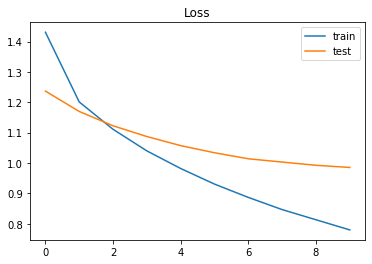

In [373]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

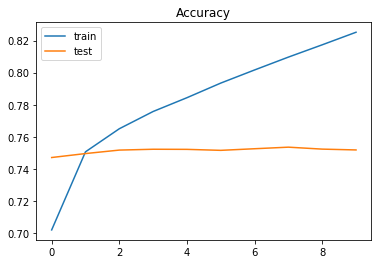

In [374]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [375]:
# Get model output
y_pred = baseline.predict(X_test)

cols = [1, 2, 3, 4, 5]

# Creating predictions table
baseline_ps = pd.DataFrame(data=y_pred, columns=cols)
y_pred_true = baseline_ps.idxmax(axis=1)

# Creating truth
baseline_truth = pd.DataFrame(data=y_test, columns=cols)
y_test_true = baseline_truth.idxmax(axis=1)

# Confusion matrix
cm = confusion_matrix(y_pred_true, y_test_true)
pd.DataFrame(cm, index=cols, columns=cols)

,1,2,3,4,5
1,34839,5028,1495,704,1203
2,1965,2835,1520,491,274
3,516,1415,2847,1512,460
4,315,745,2802,7879,4198
5,1252,720,1599,11175,72286


In [376]:
print(classification_report(y_pred_true, y_test_true))

              precision    recall  f1-score   support

           1       0.90      0.81      0.85     43269
           2       0.26      0.40      0.32      7085
           3       0.28      0.42      0.33      6750
           4       0.36      0.49      0.42     15939
           5       0.92      0.83      0.87     87032

    accuracy                           0.75    160075
   macro avg       0.54      0.59      0.56    160075
weighted avg       0.80      0.75      0.77    160075



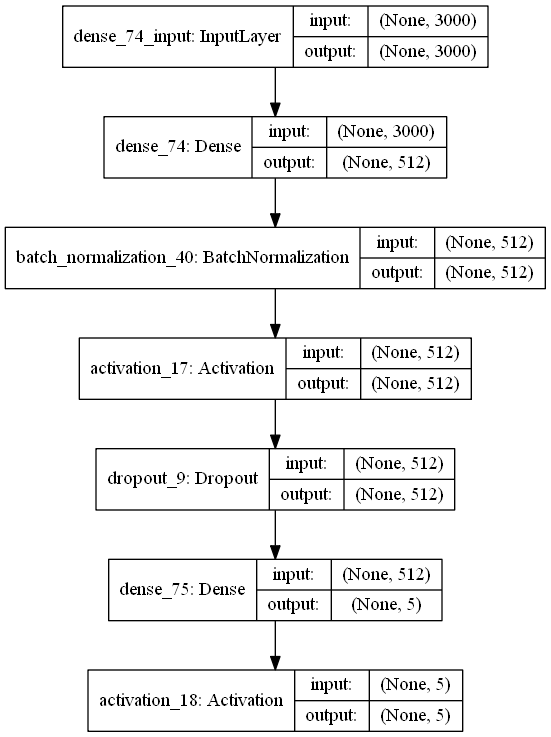

In [377]:
plot_model(baseline, to_file='baseline.png', show_shapes=True)

Let's save this model.

In [ ]:
# baseline.save('./models/baseline.h5')

### Now training with several parameter changes

In [ ]:
batch_sizes = [128, 256, 512]
epochs = [5]
learning_rates = [.01, .001, .0001]
dropout = [False, True]
batch_norm = [False, True]
regularization = [True]
optimizers = ["SGD", "RMSProp", "ADAM"]

all_lists = [batch_sizes, epochs, learning_rates, dropout, batch_norm, regularization, optimizers]

params_to_test = list(itertools.product(*all_lists))
print(len(params_to_test))

In [ ]:
models = {}
histories = {}
scores = {}

for params in params_to_test:
    print(params)
    batch_size, epochs, learning_rate, dropout, batch_norm, regularization, opt = params
    
    if opt == "SGD":
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.0, nesterov=False)
    elif opt == "RMSProp":
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate, rho=0.9)
    elif opt == "ADAM":
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.99, amsgrad=False)
    else:
        optimizer = keras.optimizers.Adadelta(learning_rate=learning_rate, rho=0.95)
    
    model = Sequential()
    model.add(Dense(512, input_shape=(max_words,), kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
    
    # Check Batch Normalization
    if batch_norm:
        model.add(BatchNormalization())
    
    model.add(Activation('relu'))
    
    # Check Dropout
    if dropout:
        model.add(Dropout(0.2))
    
    model.add(Dense(5))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        validation_split=0.1)
    
    models[params] = model
    histories[params] = history
    
    score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
    print(score)
    
    scores[params] = score

### LSTM Model


#### Specific Data Prep

In [378]:
%%time
X = yelp['text'].fillna('').values
y = pd.get_dummies(yelp['stars']).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

max_words = 3000
maxlen = 400

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# For the LSTM, we are going to pad our sequences
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

(373506,) (373506, 5)
(160075,) (160075, 5)
Wall time: 40.8 s


#### LSTM #1

In [379]:
batch_size = 512
epochs = 5

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=.001,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.99, amsgrad=False, clipvalue=.3)

lstm = Sequential()
lstm.add(Embedding(max_words, 128, input_length=maxlen))
lstm.add(SpatialDropout1D(0.2))
lstm.add(Conv1D(64, 5, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
          bias_regularizer=regularizers.l2(1e-4)))
lstm.add(MaxPooling1D(pool_size=4))
lstm.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm.add(BatchNormalization())
lstm.add(Dense(5, activation='sigmoid'))

lstm.compile(loss=my_custom_loss,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

history = lstm.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Train on 298804 samples, validate on 74702 samples
Epoch 1/5
298804/298804 [==============================] - 83s 279us/step - loss: 0.9697 - accuracy: 0.7080 - mean_absolute_error: 0.1778 - val_loss: 0.7979 - val_accuracy: 0.7487 - val_mean_absolute_error: 0.1313
Epoch 2/5
298804/298804 [==============================] - 81s 271us/step - loss: 0.7740 - accuracy: 0.7539 - mean_absolute_error: 0.1175 - val_loss: 0.7339 - val_accuracy: 0.7630 - val_mean_absolute_error: 0.1139
Epoch 3/5
298804/298804 [==============================] - 81s 271us/step - loss: 0.7270 - accuracy: 0.7642 - mean_absolute_error: 0.1097 - val_loss: 0.7215 - val_accuracy: 0.7642 - val_mean_absolute_error: 0.1077
Epoch 4/5
298804/298804 [==============================] - 81s 271us/step - loss: 0.7007 - accuracy: 0.7721 - mean_absolute_error: 0.1066 - val_loss: 0.7005 - val_accuracy: 0.7706 - val_mean_absolute_error: 0.1062
Epoch 5/5
298804/298804 [==============================] - 81s 271us/step - loss: 0.6828 - ac

#### LSTM #1: Evaluation

In [380]:
score = lstm.evaluate(X_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

160075/160075 [==============================] - 11s 66us/step
Test accuracy: 0.7741308808326721


In [381]:
lstm.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, 400, 128)          384000    
_________________________________________________________________
spatial_dropout1d_32 (Spatia (None, 400, 128)          0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 396, 64)           41024     
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 99, 64)            0         
_________________________________________________________________
lstm_32 (LSTM)               (None, 128)               98816     
_________________________________________________________________
batch_normalization_41 (Batc (None, 128)               512       
_________________________________________________________________
dense_76 (Dense)             (None, 5)               

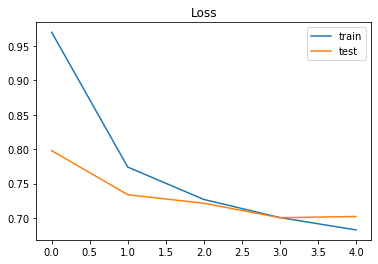

In [382]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

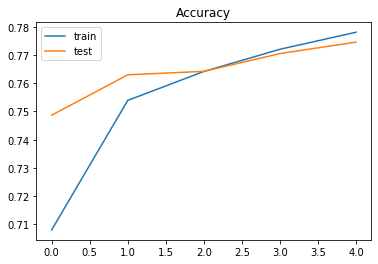

In [383]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [384]:
# Get model output
y_pred = lstm.predict(X_test)
y_pred

cols = [1, 2, 3, 4, 5]

# Creating predictions table
baseline_ps = pd.DataFrame(data=y_pred, columns=cols)
y_pred_true = baseline_ps.idxmax(axis=1)
y_pred_true

# Creating truth
baseline_truth = pd.DataFrame(data=y_test, columns=cols)
y_test_true = baseline_truth.idxmax(axis=1)
y_test_true

# Confusion matrix
cm = confusion_matrix(y_pred_true, y_test_true)
pd.DataFrame(cm, index=cols, columns=cols)

,1,2,3,4,5
1,35396,4991,1187,393,547
2,1565,3039,1387,213,69
3,406,1616,3308,1288,230
4,185,514,2953,7576,2975
5,1335,583,1428,12291,74600


In [385]:
print(classification_report(y_pred_true, y_test_true))

              precision    recall  f1-score   support

           1       0.91      0.83      0.87     42514
           2       0.28      0.48      0.36      6273
           3       0.32      0.48      0.39      6848
           4       0.35      0.53      0.42     14203
           5       0.95      0.83      0.88     90237

    accuracy                           0.77    160075
   macro avg       0.56      0.63      0.58    160075
weighted avg       0.83      0.77      0.80    160075



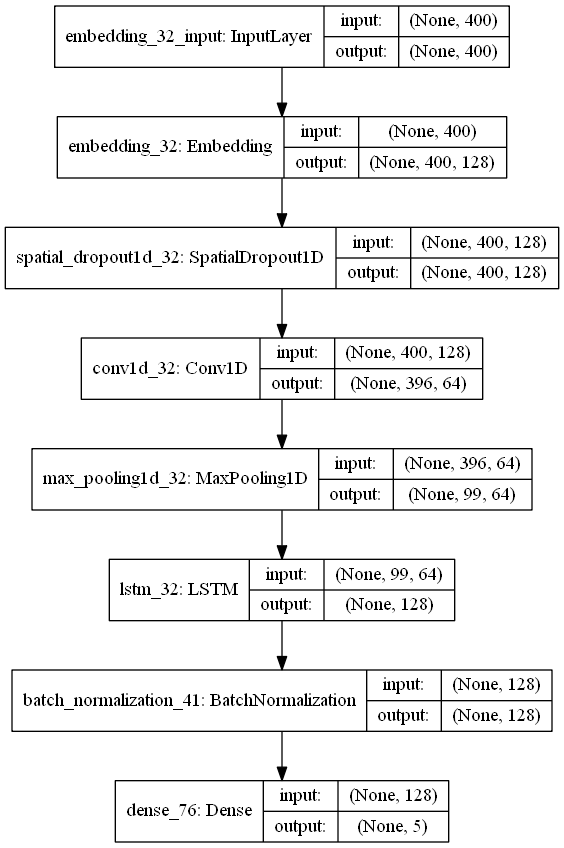

In [386]:
plot_model(lstm, to_file='baseline.png', show_shapes=True)

Let's save this model as well.

In [ ]:
# lstm.save('./models/lstm.h5')

#### LSTM #2

In [ ]:
batch_size = 128
epochs = 5

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=.001,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.99, amsgrad=False, clipvalue=.3)

lstm_v2 = Sequential()
lstm_v2.add(Embedding(max_words, 128, input_length=maxlen))
lstm_v2.add(SpatialDropout1D(0.3))
lstm_v2.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3)))
lstm_v2.add(Dense(128, activation='relu'))
lstm_v2.add(Dropout(0.2))
lstm_v2.add(Dense(128, activation='relu'))
lstm_v2.add(Dropout(0.2))
lstm_v2.add(Dense(5, activation='sigmoid'))

lstm_v2.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

history = lstm_v2.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

#### LSTM #2: Evaluation

In [ ]:
score = lstm_v2.evaluate(X_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

In [ ]:
lstm_v2.summary()

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

Let's save this model as well.

In [ ]:
lstm.save('./models/lstm_v2.h5')

### One vs. All Approach
In the one vs. all approach, it goes by the following idea:
- We will have $N$ learners for the multi-class classification problem, where $N$ is the number of classes
- For each learner $L$, we will train $L$ on our training data $X_{Train}$ and $y_{Train}$. However, $y_{Train}$ consists of only one label, making it a binary classification problem instead of multinomial
    - For instance, learner $L_1$ will still use all of $X_{Train}$, but $y_{Train}$ will now be transformed to be a binary vector $v_i$ where $i$ denotes the star rating we are attempting to predict
- Once we have concluded our training, we will then create an ensemble model (bagging) that does the following
    1. $L_1$, $L_2$, ..., $L_5$ all assign $p_i$ to each record in $X_{Test}$, where $p_i$ is the likelihood observation $x_n$ belongs to class $i$
    2. From there, our prediction is the following: $P_n = argmax(p_1, p_2, p_3, p_4, p_5)$
    
After observing the challenge datasets 5 & 6, my partner and I believe this approach is a clever way to tackle the challenges while still having a strong model.

Sources: https://developers.google.com/machine-learning/crash-course/multi-class-neural-networks/one-vs-all

In [387]:
yelp = pd.read_csv('cleaned_yelp_stemmed.csv')

X = yelp['text'].fillna('').values
y = pd.get_dummies(yelp['stars']).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# loading
# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

max_words = 3000
maxlen = 400

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (373506, 400)
X_test shape: (160075, 400)
y_train shape: (373506, 5)
y_test shape: (160075, 5)


#### Buidling all models

In [388]:
stars = np.arange(1, 6)
models = {}
histories = {}
batch_size = 512

for star in stars:
    if star in [1, 2]:
        epochs = 2
    elif star in [3, 4]:
        epochs = 3
    else:
        epochs = 4
    
    print(star)
    y_train_sub = y_train[:, star - 1]
    
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=.001,
    decay_steps=10000,
    decay_rate=0.9)

    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.99, amsgrad=False, clipvalue=.3)

    sub_lstm = Sequential()
    sub_lstm.add(Embedding(max_words, 128, input_length=maxlen))
    sub_lstm.add(SpatialDropout1D(0.2))
    sub_lstm.add(Conv1D(64, 5, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
              bias_regularizer=regularizers.l2(1e-4)))
    sub_lstm.add(MaxPooling1D(pool_size=4))
    sub_lstm.add(LSTM(128))
    sub_lstm.add(BatchNormalization())
    sub_lstm.add(Dense(8))
    sub_lstm.add(Dense(1, activation='sigmoid'))
    
    sub_lstm.compile(loss=my_custom_loss_ova,
                  optimizer=optimizer,
                  metrics=['accuracy', 'mean_absolute_error'])

    history = sub_lstm.fit(X_train, y_train_sub,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_split=0.2)
    
    models[star] = sub_lstm
    histories[star] = sub_lstm

1
Train on 298804 samples, validate on 74702 samples
Epoch 1/2
298804/298804 [==============================] - 78s 262us/step - loss: 0.3618 - accuracy: 0.9112 - mean_absolute_error: 0.1195 - val_loss: 0.3157 - val_accuracy: 0.9185 - val_mean_absolute_error: 0.1026
Epoch 2/2
298804/298804 [==============================] - 78s 261us/step - loss: 0.2660 - accuracy: 0.9350 - mean_absolute_error: 0.0849 - val_loss: 0.3055 - val_accuracy: 0.9227 - val_mean_absolute_error: 0.0926
2
Train on 298804 samples, validate on 74702 samples
Epoch 1/2
298804/298804 [==============================] - 79s 263us/step - loss: 0.3496 - accuracy: 0.9257 - mean_absolute_error: 0.1120 - val_loss: 0.3363 - val_accuracy: 0.9324 - val_mean_absolute_error: 0.0762
Epoch 2/2
298804/298804 [==============================] - 78s 261us/step - loss: 0.2749 - accuracy: 0.9364 - mean_absolute_error: 0.0843 - val_loss: 0.2991 - val_accuracy: 0.9346 - val_mean_absolute_error: 0.0763
3
Train on 298804 samples, validate on

#### Building an ensemble model (maximization between learners) for all trained models
##### Testing

In [389]:
%%time
# Evaluating the models above (TEST)
y_test_und = pd.DataFrame(y_test)
y_test_true = pd.DataFrame(y_test_und.columns[np.where(y_test_und!=0)[1]]) + 1

# Unload models
lstm_1, lstm_2, lstm_3, lstm_4, lstm_5 = models[1], models[2], models[3], models[4], models[5]

## Predicting the probability for each observation each model
print("Predicting 1 star")
one_star_ps = lstm_1.predict(X_test)
print("Predicting 2 star")
two_star_ps = lstm_2.predict(X_test)
print("Predicting 3 star")
three_star_ps = lstm_3.predict(X_test)
print("Predicting 4 star")
four_star_ps = lstm_4.predict(X_test)
print("Predicting 5 star")
five_star_ps = lstm_5.predict(X_test)

data = [one_star_ps.flatten(), two_star_ps.flatten(), three_star_ps.flatten(), four_star_ps.flatten(), five_star_ps.flatten()]
cols = [1, 2, 3, 4, 5]
ps = pd.DataFrame(data=data, index=cols).T

ps["pred"] = ps.idxmax(axis=1)
ps.head()

print(MAE(ps["pred"], y_test_true[0]))
print(Accuracy(ps["pred"], y_test_true[0]))

Predicting 1 star
Predicting 2 star
Predicting 3 star
Predicting 4 star
Predicting 5 star
0.3318132125566141
0.7664844604091832
Wall time: 5min 40s


In [390]:
# Confusion matrix
cm = confusion_matrix(ps["pred"], y_test_true[0])
pd.DataFrame(cm, index=cols, columns=cols)

,1,2,3,4,5
1,35053,4857,1199,329,398
2,1038,2387,850,143,41
3,400,1383,2718,760,109
4,538,1128,3300,6978,2314
5,1858,988,2196,13551,75559


In [391]:
print(classification_report(ps["pred"], y_test_true[0]))

              precision    recall  f1-score   support

           1       0.90      0.84      0.87     41836
           2       0.22      0.54      0.31      4459
           3       0.26      0.51      0.35      5370
           4       0.32      0.49      0.39     14258
           5       0.96      0.80      0.88     94152

    accuracy                           0.77    160075
   macro avg       0.53      0.63      0.56    160075
weighted avg       0.85      0.77      0.80    160075



#### Saving the models


In [ ]:
# lstm_1.save("./models/one_star.h5")
# lstm_2.save("./models/two_star.h5")
# lstm_3.save("./models/three_star.h5")
# lstm_4.save("./models/four_star.h5")
# lstm_5.save("./models/five_star.h5")

### Ensemble on Test Set

In [392]:
yelp = pd.read_csv('cleaned_yelp_stemmed.csv')

X = yelp['text'].fillna('').values
y = pd.get_dummies(yelp['stars'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

max_words = 3000
maxlen = 400

# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle) 

print(y_test)    

necc_cols = [1, 2, 3, 4, 5]
for col in necc_cols:
    if col not in y_test.columns:
        y_test[col] = 0
        
y_test = y_test[necc_cols]
y_test = y_test.values

X_baseline = tokenizer.texts_to_matrix(X_test)
X_lstm = tokenizer.texts_to_sequences(X_test)
X_lstm = pad_sequences(X_lstm, maxlen=maxlen)

(373506,) (373506, 5)
(160075,) (160075, 5)
        1  2  3  4  5
255947  0  0  0  0  1
261035  0  0  0  0  1
355633  0  0  0  0  1
205506  0  0  0  0  1
97222   0  0  0  1  0
...    .. .. .. .. ..
491832  0  0  0  0  1
311959  0  0  0  0  1
140524  1  0  0  0  0
125037  0  0  1  0  0
200135  0  0  0  1  0

[160075 rows x 5 columns]


In [ ]:
# # Trying our pretrained models
# # Optimizer
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=.001, decay_steps=10000, decay_rate=0.9)
# optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.99, amsgrad=False, clipvalue=.3)

# # Baseline
# baseline = load_model('./models/baseline.h5')

# baseline.compile(loss='categorical_crossentropy',
#               optimizer=optimizer,
#               metrics=['accuracy'])

# # LSTM
# lstm = load_model('./models/lstm.h5')

# lstm.compile(loss='categorical_crossentropy',
#               optimizer=optimizer,
#               metrics=['accuracy'])


# # One vs. all
# lstm_1 = load_model('./models/one_star.h5')

# lstm_1.compile(loss='binary_crossentropy',
#                   optimizer=optimizer,
#                   metrics=['accuracy'])

# lstm_2 = load_model('./models/two_star.h5')

# lstm_2.compile(loss='binary_crossentropy',
#                   optimizer=optimizer,
#                   metrics=['accuracy'])

# lstm_3 = load_model('./models/three_star.h5')

# lstm_3.compile(loss='binary_crossentropy',
#                   optimizer=optimizer,
#                   metrics=['accuracy'])

# lstm_4 = load_model('./models/four_star.h5')

# lstm_4.compile(loss='binary_crossentropy',
#                   optimizer=optimizer,
#                   metrics=['accuracy'])

# lstm_5 = load_model('./models/five_star.h5')

# lstm_5.compile(loss='binary_crossentropy',
#                   optimizer=optimizer,
#                   metrics=['accuracy'])

In [393]:
cols = [1, 2, 3, 4, 5]
# Baseline
print("Baseline")
baseline_preds = pd.DataFrame(baseline.predict(X_baseline), columns=cols)
baseline_preds['baseline_pred'] = baseline_preds.idxmax(axis=1)

# LSTM
print("LSTM")
lstm_preds = pd.DataFrame(lstm.predict(X_lstm), columns=cols)
lstm_preds['lstm_pred'] = lstm_preds.idxmax(axis=1)

# One vs. all
print("OVA")
one_star_ps = lstm_1.predict(X_lstm)
two_star_ps = lstm_2.predict(X_lstm)
three_star_ps = lstm_3.predict(X_lstm)
four_star_ps = lstm_4.predict(X_lstm)
five_star_ps = lstm_5.predict(X_lstm)

data = [one_star_ps.flatten(), two_star_ps.flatten(), three_star_ps.flatten(), four_star_ps.flatten(), five_star_ps.flatten()]
ova_preds = pd.DataFrame(data=data, index=cols).T

ova_preds["ova_pred"] = ova_preds.idxmax(axis=1)

all_preds = pd.DataFrame([baseline_preds['baseline_pred'], lstm_preds['lstm_pred'], ova_preds['ova_pred']]).T
all_preds["final_pred"] = all_preds.mode(axis=1)[0]

Baseline
LSTM
OVA


In [394]:
print([MAE(all_preds["final_pred"], pd.DataFrame(data=y_test, columns=cols).idxmax(axis=1)), Accuracy(all_preds["final_pred"], pd.DataFrame(data=y_test, columns=cols).idxmax(axis=1))])

[0.30764329220677805, 0.7744307355926909]


In [395]:
# Confusion matrix
cm = confusion_matrix(all_preds["final_pred"], pd.DataFrame(data=y_test, columns=cols).idxmax(axis=1))
pd.DataFrame(cm, index=cols, columns=cols)

,1,2,3,4,5
1,35990,5462,1622,590,604
2,1210,2887,1352,353,119
3,273,1230,2931,1101,259
4,175,556,2796,7303,2583
5,1239,608,1562,12414,74856


In [396]:
print(classification_report(y_pred_true, y_test_true))

              precision    recall  f1-score   support

           1       0.91      0.83      0.87     42514
           2       0.28      0.48      0.36      6273
           3       0.32      0.48      0.39      6848
           4       0.35      0.53      0.42     14203
           5       0.95      0.83      0.88     90237

    accuracy                           0.77    160075
   macro avg       0.56      0.63      0.58    160075
weighted avg       0.83      0.77      0.80    160075



# Challenges
### Challenge 5

In [397]:
c5 = pd.read_json("./yelp_challenge_5_with_answers.jsonl", lines = True)
print(c5.shape)
c5.head()

(500, 3)


,review_id,text,stars
0,50,I went to this campus for 1 semester. I was in...,2
1,51,I have rated it a two star based on its compar...,2
2,52,"Just like most of the reviews, we ordered and ...",2
3,53,I only go here if it is an emergency. I HATE i...,2
4,54,Rude staff. I got 60 feeder fish and about 15 ...,2


##### Quick EDA

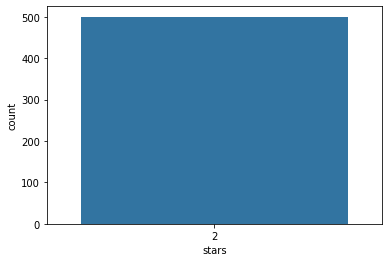

In [398]:
sns.countplot(c5['stars'])

##### Pre-processing

In [399]:
c5['text'] = c5['text'].apply(clean_text)
c5.head()

,review_id,text,stars
0,50,i went to thi campu for 1 semest i wa in busi ...,2
1,51,i have rate it a two star base on it compariso...,2
2,52,just like most of the review we order and paid...,2
3,53,i onli go here if it is an emerg i hate it tha...,2
4,54,rude staff i got 60 feeder fish and about 15 w...,2


##### Load previous tokenizer

In [400]:
X = c5['text'].fillna('').values
y = pd.get_dummies(c5['stars'])

# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

max_words    
    
necc_cols = [1, 2, 3, 4, 5]
for col in necc_cols:
    if col not in y.columns:
        y[col] = 0
        
y = y[necc_cols]
y = y.values

X_baseline = tokenizer.texts_to_matrix(X)
X_lstm = tokenizer.texts_to_sequences(X)
X_lstm = pad_sequences(X_lstm, maxlen=400)

##### Load and compile models

In [401]:
# # Baseline
# baseline = load_model('./models/baseline.h5')

# baseline.compile(loss='categorical_crossentropy',
#               optimizer=optimizer,
#               metrics=['accuracy'])

# # LSTM
# lstm = load_model('./models/lstm.h5')

# lstm.compile(loss='categorical_crossentropy',
#               optimizer=optimizer,
#               metrics=['accuracy'])


# # One vs. all
# lstm_1 = load_model('./models/one_star.h5')

# lstm_1.compile(loss='binary_crossentropy',
#                   optimizer=optimizer,
#                   metrics=['accuracy'])

# lstm_2 = load_model('./models/two_star.h5')

# lstm_2.compile(loss='binary_crossentropy',
#                   optimizer=optimizer,
#                   metrics=['accuracy'])

# lstm_3 = load_model('./models/three_star.h5')

# lstm_3.compile(loss='binary_crossentropy',
#                   optimizer=optimizer,
#                   metrics=['accuracy'])

# lstm_4 = load_model('./models/four_star.h5')

# lstm_4.compile(loss='binary_crossentropy',
#                   optimizer=optimizer,
#                   metrics=['accuracy'])

# lstm_5 = load_model('./models/five_star.h5')

# lstm_5.compile(loss='binary_crossentropy',
#                   optimizer=optimizer,
#                   metrics=['accuracy'])

##### Evaluate Models

In [402]:
# Baseline
print(baseline.evaluate(X_baseline, y))

# LSTM
print(lstm.evaluate(X_lstm, y))

# One vs. All
one_star_ps = lstm_1.predict(X_lstm)
two_star_ps = lstm_2.predict(X_lstm)
three_star_ps = lstm_3.predict(X_lstm)
four_star_ps = lstm_4.predict(X_lstm)
five_star_ps = lstm_5.predict(X_lstm)

data = [one_star_ps.flatten(), two_star_ps.flatten(), three_star_ps.flatten(), four_star_ps.flatten(), five_star_ps.flatten()]
cols = [1, 2, 3, 4, 5]
ps = pd.DataFrame(data=data, index=cols).T

ps["ova_pred"] = ps.idxmax(axis=1)

print([MAE(ps["ova_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1)), Accuracy(ps["ova_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1))])

500/500 [==============================] - 0s 98us/step
[2.3530872859954832, 0.2939999997615814, 0.288883239030838]
500/500 [==============================] - 0s 550us/step
[1.7786740112304686, 0.2800000011920929, 0.25147223472595215]
[1.04, 0.25]


##### Attempt Ensemble

In [403]:
# Baseline
baseline_preds = pd.DataFrame(baseline.predict(X_baseline), columns=cols)
baseline_preds['baseline_pred'] = baseline_preds.idxmax(axis=1)

# LSTM
lstm_preds = pd.DataFrame(lstm.predict(X_lstm), columns=cols)
lstm_preds['lstm_pred'] = lstm_preds.idxmax(axis=1)

# One vs. all
ova_preds = ps

all_preds = pd.DataFrame([baseline_preds['baseline_pred'], lstm_preds['lstm_pred'], ova_preds['ova_pred']]).T
all_preds["final_pred"] = all_preds.mode(axis=1)[0]

print([MAE(all_preds["final_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1)), Accuracy(all_preds["final_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1))])

[0.874, 0.29]


##### Misc.

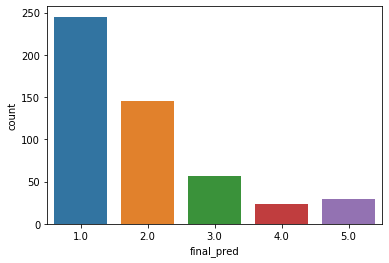

In [404]:
sns.countplot(all_preds["final_pred"])

### Challenge 6

In [405]:
c6 = pd.read_json("./yelp_challenge_6_with_answers.jsonl", lines = True)
print(c6.shape)
c6.head()

(500, 3)


,review_id,text,stars
0,60,Amazing for Trees\n\n$20 for a 5 gallon . I wi...,5
1,61,How the hell can Taco Bell be closed before mi...,5
2,62,I actually had no intention of visiting this p...,5
3,63,Yesterday around 3:30 pm I was driving west on...,5
4,64,DR FITZMAURICE did surgery on both hands on th...,5


##### Quick EDA

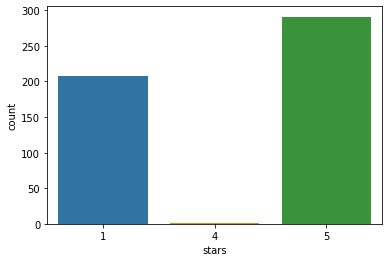

In [406]:
sns.countplot(c6['stars'])

##### Pre-processing

In [407]:
c6['text'] = c6['text'].apply(clean_text)
c6.head()

,review_id,text,stars
0,60,amaz for tree 20 for a 5 gallon i will never g...,5
1,61,how the hell can taco bell be close befor midn...,5
2,62,i actual had no intent of visit thi place at a...,5
3,63,yesterday around 3 30 pm i wa drive west on pi...,5
4,64,dr fitzmauric did surgeri on both hand on the ...,5


##### Load previous tokenizer

In [408]:
X = c6['text'].fillna('').values
y = pd.get_dummies(c6['stars'])

# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

max_words    
    
necc_cols = [1, 2, 3, 4, 5]
for col in necc_cols:
    if col not in y.columns:
        y[col] = 0
        
y = y[necc_cols]
y = y.values

X_baseline = tokenizer.texts_to_matrix(X)
X_lstm = tokenizer.texts_to_sequences(X)
X_lstm = pad_sequences(X_lstm, maxlen=400)

##### Load and compile models

In [409]:
# # Baseline
# baseline = load_model('./models/baseline.h5')

# baseline.compile(loss='categorical_crossentropy',
#               optimizer=optimizer,
#               metrics=['accuracy'])

# # LSTM
# lstm = load_model('./models/lstm.h5')

# lstm.compile(loss='categorical_crossentropy',
#               optimizer=optimizer,
#               metrics=['accuracy'])


# # One vs. all
# lstm_1 = load_model('./models/one_star.h5')

# lstm_1.compile(loss='binary_crossentropy',
#                   optimizer=optimizer,
#                   metrics=['accuracy'])

# lstm_2 = load_model('./models/two_star.h5')

# lstm_2.compile(loss='binary_crossentropy',
#                   optimizer=optimizer,
#                   metrics=['accuracy'])

# lstm_3 = load_model('./models/three_star.h5')

# lstm_3.compile(loss='binary_crossentropy',
#                   optimizer=optimizer,
#                   metrics=['accuracy'])

# lstm_4 = load_model('./models/four_star.h5')

# lstm_4.compile(loss='binary_crossentropy',
#                   optimizer=optimizer,
#                   metrics=['accuracy'])

# lstm_5 = load_model('./models/five_star.h5')

# lstm_5.compile(loss='binary_crossentropy',
#                   optimizer=optimizer,
#                   metrics=['accuracy'])

##### Evaluate Models

In [410]:
# Baseline
print(baseline.evaluate(X_baseline, y))

# LSTM
print(lstm.evaluate(X_lstm, y))

# One vs. All
one_star_ps = lstm_1.predict(X_lstm)
two_star_ps = lstm_2.predict(X_lstm)
three_star_ps = lstm_3.predict(X_lstm)
four_star_ps = lstm_4.predict(X_lstm)
five_star_ps = lstm_5.predict(X_lstm)

data = [one_star_ps.flatten(), two_star_ps.flatten(), three_star_ps.flatten(), four_star_ps.flatten(), five_star_ps.flatten()]
cols = [1, 2, 3, 4, 5]
ps = pd.DataFrame(data=data, index=cols).T

ps["ova_pred"] = ps.idxmax(axis=1)

print([MAE(ps["ova_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1)), Accuracy(ps["ova_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1))])

500/500 [==============================] - 0s 90us/step
[2.7605343475341795, 0.4359999895095825, 0.2512551546096802]
500/500 [==============================] - 0s 566us/step
[2.4968312091827394, 0.4259999990463257, 0.2326160967350006]
[2.106, 0.44]


##### Attempt Ensemble

In [411]:
# Baseline
baseline_preds = pd.DataFrame(baseline.predict(X_baseline), columns=cols)
baseline_preds['baseline_pred'] = baseline_preds.idxmax(axis=1)

# LSTM
lstm_preds = pd.DataFrame(lstm.predict(X_lstm), columns=cols)
lstm_preds['lstm_pred'] = lstm_preds.idxmax(axis=1)

# One vs. all
ova_preds = ps

all_preds = pd.DataFrame([baseline_preds['baseline_pred'], lstm_preds['lstm_pred'], ova_preds['ova_pred']]).T
all_preds["final_pred"] = all_preds.mode(axis=1)[0]

print([MAE(all_preds["final_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1)), Accuracy(all_preds["final_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1))])

[2.092, 0.45]


##### Misc.

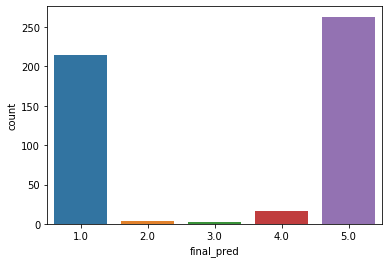

In [412]:
sns.countplot(all_preds["final_pred"])

### Challenge 3

In [413]:
c3 = pd.read_json("./yelp_challenge_3_with_answers.jsonl", lines = True)
print(c3.shape)
c3.head()

(534, 3)


,review_id,text,stars
0,30,We stopped here for lunch today and were pleas...,4
1,31,We went for a quick lunch here - it's all reas...,3
2,32,"Very bad food, avoid it. We were a group of 4 ...",2
3,33,Bring a friend or two to help open the door. I...,3
4,34,Ukai serves some of the best sushi and sashimi...,4


##### Quick EDA

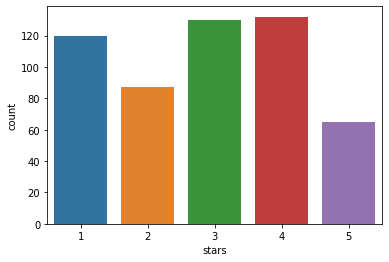

In [414]:
sns.countplot(c3['stars'])

##### Pre-processing

In [415]:
c3['text'] = c3['text'].apply(clean_text)
c3.head()

,review_id,text,stars
0,30,we stop here for lunch today and were pleasant...,4
1,31,we went for a quick lunch here it s all reason...,3
2,32,veri bad food avoid it we were a group of 4 an...,2
3,33,bring a friend or two to help open the door i ...,3
4,34,ukai serv some of the best sushi and sashimi i...,4


##### Load previous tokenizer

In [416]:
X = c3['text'].fillna('').values
y = pd.get_dummies(c3['stars'])

# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

max_words    
    
necc_cols = [1, 2, 3, 4, 5]
for col in necc_cols:
    if col not in y.columns:
        y[col] = 0
        
y = y[necc_cols]
y = y.values

X_baseline = tokenizer.texts_to_matrix(X)
X_lstm = tokenizer.texts_to_sequences(X)
X_lstm = pad_sequences(X_lstm, maxlen=400)

##### Load and compile models

In [417]:
# # Baseline
# baseline = load_model('./models/baseline.h5')

# baseline.compile(loss='categorical_crossentropy',
#               optimizer=optimizer,
#               metrics=['accuracy'])

# # LSTM
# lstm = load_model('./models/lstm.h5')

# lstm.compile(loss='categorical_crossentropy',
#               optimizer=optimizer,
#               metrics=['accuracy'])


# # One vs. all
# lstm_1 = load_model('./models/one_star.h5')

# lstm_1.compile(loss='binary_crossentropy',
#                   optimizer=optimizer,
#                   metrics=['accuracy'])

# lstm_2 = load_model('./models/two_star.h5')

# lstm_2.compile(loss='binary_crossentropy',
#                   optimizer=optimizer,
#                   metrics=['accuracy'])

# lstm_3 = load_model('./models/three_star.h5')

# lstm_3.compile(loss='binary_crossentropy',
#                   optimizer=optimizer,
#                   metrics=['accuracy'])

# lstm_4 = load_model('./models/four_star.h5')

# lstm_4.compile(loss='binary_crossentropy',
#                   optimizer=optimizer,
#                   metrics=['accuracy'])

# lstm_5 = load_model('./models/five_star.h5')

# lstm_5.compile(loss='binary_crossentropy',
#                   optimizer=optimizer,
#                   metrics=['accuracy'])

##### Evaluate Models

In [418]:
# Baseline
print(baseline.evaluate(X_baseline, y))

# LSTM
print(lstm.evaluate(X_lstm, y))

# One vs. All
one_star_ps = lstm_1.predict(X_lstm)
two_star_ps = lstm_2.predict(X_lstm)
three_star_ps = lstm_3.predict(X_lstm)
four_star_ps = lstm_4.predict(X_lstm)
five_star_ps = lstm_5.predict(X_lstm)

data = [one_star_ps.flatten(), two_star_ps.flatten(), three_star_ps.flatten(), four_star_ps.flatten(), five_star_ps.flatten()]
cols = [1, 2, 3, 4, 5]
ps = pd.DataFrame(data=data, index=cols).T

ps["ova_pred"] = ps.idxmax(axis=1)

print([MAE(ps["ova_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1)), Accuracy(ps["ova_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1))])

534/534 [==============================] - 0s 86us/step
[1.4272420200962253, 0.5617977380752563, 0.2057403028011322]
534/534 [==============================] - 0s 502us/step
[1.1382992944020904, 0.5898876190185547, 0.1856943964958191]
[0.5880149812734082, 0.5299625468164794]


##### Attempt Ensemble

In [419]:
# Baseline
baseline_preds = pd.DataFrame(baseline.predict(X_baseline), columns=cols)
baseline_preds['baseline_pred'] = baseline_preds.idxmax(axis=1)

# LSTM
lstm_preds = pd.DataFrame(lstm.predict(X_lstm), columns=cols)
lstm_preds['lstm_pred'] = lstm_preds.idxmax(axis=1)

# One vs. all
ova_preds = ps

all_preds = pd.DataFrame([baseline_preds['baseline_pred'], lstm_preds['lstm_pred'], ova_preds['ova_pred']]).T
all_preds["final_pred"] = all_preds.mode(axis=1)[0]

print([MAE(all_preds["final_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1)), Accuracy(all_preds["final_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1))])

[0.46629213483146065, 0.5936329588014981]


##### Misc.

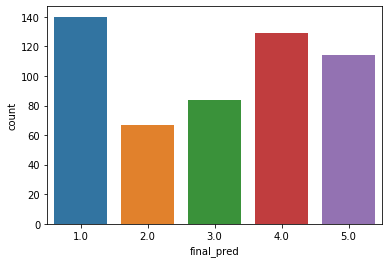

In [420]:
sns.countplot(all_preds["final_pred"])

### Challenge 8

In [421]:
c8 = pd.read_json("./yelp_challenge_8_with_answers.jsonl", lines = True)
print(c8.shape)
c8.head()

(500, 3)


,review_id,text,stars
0,qOOv-A-vo3kMT0yi4jIIlg,Not bad for fast food.,4
1,uqxkO6B6w_sIDSAGr0k_0A,Une institution du café,4
2,0o_gGSU0m_4QyNLWEHKgug,J ai vraiment aimé !!!!,4
3,BKAj-fKWW5G3yt3xAkbUCQ,They have good poutine.,4
4,fAhp8IwuGNT0ywKmsCs6VQ,Very old and dirty vans.,1


##### Quick EDA

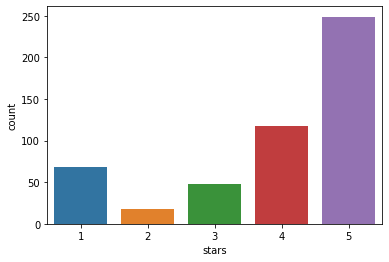

In [422]:
sns.countplot(c8['stars'])

##### Pre-processing

In [423]:
c8['text'] = c8['text'].apply(clean_text)
c8.head()

C:\Users\Tanner\Anaconda3\envs\yelp\lib\site-packages\bs4\__init__.py:398: UserWarning: "https://casetext.com/case/united-states-v-butterbaugh-2" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  markup


,review_id,text,stars
0,qOOv-A-vo3kMT0yi4jIIlg,not bad for fast food,4
1,uqxkO6B6w_sIDSAGr0k_0A,une institut du caf,4
2,0o_gGSU0m_4QyNLWEHKgug,j ai vraiment aim,4
3,BKAj-fKWW5G3yt3xAkbUCQ,they have good poutin,4
4,fAhp8IwuGNT0ywKmsCs6VQ,veri old and dirti van,1


##### Load previous tokenizer

In [424]:
X = c8['text'].fillna('').values
y = pd.get_dummies(c8['stars'])

# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

max_words    
    
necc_cols = [1, 2, 3, 4, 5]
for col in necc_cols:
    if col not in y.columns:
        y[col] = 0
        
y = y[necc_cols]
y = y.values

X_baseline = tokenizer.texts_to_matrix(X)
X_lstm = tokenizer.texts_to_sequences(X)
X_lstm = pad_sequences(X_lstm, maxlen=400)

##### Load and compile models

In [425]:
# # Baseline
# baseline = load_model('./models/baseline.h5')

# baseline.compile(loss='categorical_crossentropy',
#               optimizer=optimizer,
#               metrics=['accuracy'])

# # LSTM
# lstm = load_model('./models/lstm.h5')

# lstm.compile(loss='categorical_crossentropy',
#               optimizer=optimizer,
#               metrics=['accuracy'])


# # One vs. all
# lstm_1 = load_model('./models/one_star.h5')

# lstm_1.compile(loss='binary_crossentropy',
#                   optimizer=optimizer,
#                   metrics=['accuracy'])

# lstm_2 = load_model('./models/two_star.h5')

# lstm_2.compile(loss='binary_crossentropy',
#                   optimizer=optimizer,
#                   metrics=['accuracy'])

# lstm_3 = load_model('./models/three_star.h5')

# lstm_3.compile(loss='binary_crossentropy',
#                   optimizer=optimizer,
#                   metrics=['accuracy'])

# lstm_4 = load_model('./models/four_star.h5')

# lstm_4.compile(loss='binary_crossentropy',
#                   optimizer=optimizer,
#                   metrics=['accuracy'])

# lstm_5 = load_model('./models/five_star.h5')

# lstm_5.compile(loss='binary_crossentropy',
#                   optimizer=optimizer,
#                   metrics=['accuracy'])

##### Evaluate Models

In [426]:
# Baseline
print(baseline.evaluate(X_baseline, y))

# LSTM
print(lstm.evaluate(X_lstm, y))

# One vs. All
one_star_ps = lstm_1.predict(X_lstm)
two_star_ps = lstm_2.predict(X_lstm)
three_star_ps = lstm_3.predict(X_lstm)
four_star_ps = lstm_4.predict(X_lstm)
five_star_ps = lstm_5.predict(X_lstm)

data = [one_star_ps.flatten(), two_star_ps.flatten(), three_star_ps.flatten(), four_star_ps.flatten(), five_star_ps.flatten()]
cols = [1, 2, 3, 4, 5]
ps = pd.DataFrame(data=data, index=cols).T

ps["ova_pred"] = ps.idxmax(axis=1)

print([MAE(ps["ova_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1)), Accuracy(ps["ova_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1))])

500/500 [==============================] - 0s 90us/step
[1.2647738161087037, 0.6380000114440918, 0.1816849410533905]
500/500 [==============================] - 0s 510us/step
[1.06033664894104, 0.6340000033378601, 0.16163282096385956]
[0.576, 0.624]


##### Attempt Ensemble

In [427]:
# Baseline
baseline_preds = pd.DataFrame(baseline.predict(X_baseline), columns=cols)
baseline_preds['baseline_pred'] = baseline_preds.idxmax(axis=1)

# LSTM
lstm_preds = pd.DataFrame(lstm.predict(X_lstm), columns=cols)
lstm_preds['lstm_pred'] = lstm_preds.idxmax(axis=1)

# One vs. all
ova_preds = ps

all_preds = pd.DataFrame([baseline_preds['baseline_pred'], lstm_preds['lstm_pred'], ova_preds['ova_pred']]).T
all_preds["final_pred"] = all_preds.mode(axis=1)[0]

print([MAE(all_preds["final_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1)), Accuracy(all_preds["final_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1))])

[0.536, 0.644]


##### Misc.

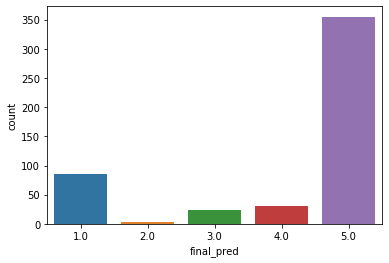

In [428]:
sns.countplot(all_preds["final_pred"])